In [11]:
%colors nocolor 
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, \
  NormalizeObservation, NormalizeReward


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

def plot_policy(policy):
  pos = np.linspace(-4.8, 4.8, 100)
  vel = np.random.random(size=(10000, 1)) * 0.1
  ang = np.linspace(-0.418, 0.418, 100)
  ang_vel = np.random.random(size=(10000, 1)) * 0.1

  g1, g2 = np.meshgrid(pos, ang)
  grid = np.stack((g1,g2), axis=-1)
  grid = grid.reshape(-1, 2)
  grid = np.hstack((grid, vel, ang_vel))

  probs = policy(grid).detach().numpy()
  probs_left = probs[:, 0]

  probs_left = probs_left.reshape(100, 100)
  probs_left = np.flip(probs_left, axis=1)

  plt.figure(figsize=(8, 8))
  plt.imshow(probs_left, cmap='coolwarm')
  plt.colorbar()
  plt.clim(0, 1)
  plt.title("P(left | s)", size=20)
  plt.xlabel("Cart Position", size=14)
  plt.ylabel("Pole angle", size=14)
  plt.xticks(ticks=[0, 50, 100], labels=['-4.8', '0', '4.8'])
  plt.yticks(ticks=[100, 50, 0], labels=['-0.418', '0', '0.418'])


def test_env(env_name, policy, obs_rms):
  env = gym.make(env_name)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: True)
  # env = NormalizeObservation(env)
  env.obs_rms = obs_rms

  for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
      action = policy(obs).multinomial(1).cpu().item()
      obs, _, done, _ = env.step(action)
  del env


def display_video(episode=0):
  video_file = open(f'videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [2]:
class GradientPolicy(nn.Module):

    def __init__(self, in_features, n_actions, hidden_size=128):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_actions)

    def forward(self, state):
        x = torch.tensor(state).float().to(device) # create a tensor of the state and send it to the right device
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1) # apply softmax to the final dimension
        return x # vector of probabilities
    
def create_envs(env_name, num_envs):
    env = gym.vector.make(env_name, num_envs)
    env = RecordEpisodeStatistics(env)
    env = NormalizeObservation(env)
    env = NormalizeReward(env)
    return env        

class RLDataset(IterableDataset):
    def __init__(self, env, policy, steps_per_epoch, gamma):
        super().__init__()
        self.env = env
        self.policy = policy
        self.gamma = gamma
        self.steps_per_epoch = steps_per_epoch
        self.obs = env.reset()

    @torch.no_grad()
    def __iter__(self):
        transitions = []
        for step in range(self.steps_per_epoch):
            action = self.policy(self.obs) # [[p1, p2, p3], [p1, p2, p3]]
            action = action.multinomial(1 ).cpu().numpy() # [[a1], [a2]]
            next_obs, reward, done = self.env.step(action.flatten()) # [a1, a2]
            transitions.append([self.obs, action, reward, done])
            self.obs = next_obs

        obs_b, action_b, reward_b, done_b = map(np.stack, zip(*transitions)) 
        running_return = np.zeros(self.env.num_envs, dtype=np.float32)
        return_b = np.zeros_like(reward_b)
        for row in range(self.steps_per_epoch-1, -1, -1):
            running_return = reward_b[row] + (1-done_b[row]) * self.gamma * running_return
            return_b[row] = running_return

        # combine all the environments into 1 single list
        num_samples = self.env.num_envs * self.steps_per_epoch
        obs_b  = obs_b.reshape(num_samples, -1)
        action_b = action_b.reshape(num_samples, -1)
        return_b = return_b.reshape(num_samples, -1)

        # shuffle transitions
        idx = list(range(num_samples))
        random.shuffle(idx)

        # return one by one the training items
        for i in idx:
            yield obs_b[i], action_b[i], return_b[i]

REINFORCE Algorithm

In [3]:
class REINFORCE(LightningModule):
    def __init__(self, env_name, num_envs=8, samples_per_epoch=1000, batch_size=1024,
                 hidden_size=64, policy_lr=.001, gamma=.99, entropy_coef=.001, optim=AdamW):
        super().__init__()

        self.env = create_envs(env_name, num_envs)
        obs_size = self.env.single_observation_space.shape[0]
        n_actions = self.env.single_action_space.n

        self.policy = GradientPolicy(obs_size, n_actions, hidden_size)
        self.dataset = RLDataset(self.env, self.policy, samples_per_epoch, gamma)

        self.save_hyperparameters()

    def configure_optimizers(self):
        return self.hparams.optim(self.policy.parameters(), lr=self.hparams.policy_lr)
    
    def train_dataloader(self):
        return DataLoader(dataset=self.dataset, batch_size=self.hparams.batch_size)
    
    def training_step(self, batch, batch_index):
        obs_b, action_b, return_b = batch # batch is from dataloader

        probs_b = self.policy(obs_b)
        log_probs_b = torch.log(probs_b + 1e-6)
        action_log_prob_b = log_probs_b.gather(1, action_b)

        entropy = - torch.sum(probs_b * log_probs_b, dim=-1, keepdim=True)

        pg_loss = - action_log_prob_b * return_b # why no alpha???
        total_loss = torch.mean(pg_loss - self.hparams.entropy_coef * entropy)

        self.log("episode/PG Loss", pg_loss.mean())
        self.log("episode/Entropy", entropy.mean())

        return total_loss
    
    def on_train_epoch_end(self, *args, **kwargs):
        self.log("episode/Return", self.env.return_queue[-1])



Train the policy

In [15]:
algo = REINFORCE('CartPole-v1')

trainer = Trainer(max_epochs=500)

trainer.fit(algo)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type           | Params
------------------------------------------
0 | policy | GradientPolicy | 4.6 K 
------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/tmp/ipykernel_265886/795761382.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(state).float().to(device) # create a tensor of the state and send it to the right device
`Trainer.fit` stopped: `max_epochs=500` reached.


Train for 200 more epochs ;)

In [26]:
trainer = Trainer(max_epochs=200)
trainer.fit(algo)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type           | Params
------------------------------------------
0 | policy | GradientPolicy | 4.6 K 
------------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/tmp/ipykernel_265886/795761382.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(state).float().to(device) # create a tensor of the state and send it to the right device
`Trainer.fit` stopped: `max_epochs=200` reached.


In [27]:
test_env('CartPole-v1', algo.policy, algo.env.obs_rms)

/home/weiminn/Documents/reinforcement/venv/lib/python3.8/site-packages/gym/wrappers/record_video.py:41: UserWarning: WARN: Overwriting existing videos at /home/weiminn/Documents/reinforcement/10_Policy_Gradient/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [31]:
display_video(episode=8)

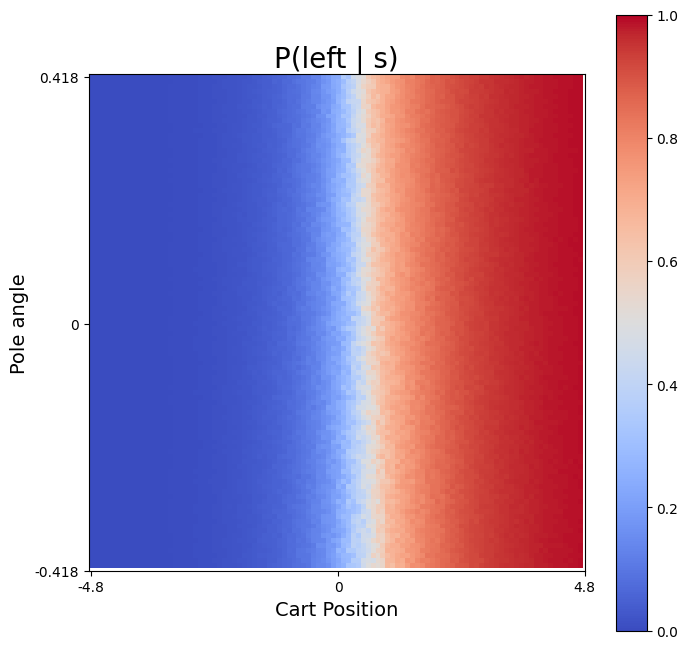

In [32]:
plot_policy(algo.policy)